In [47]:
import os
import tempfile
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error,r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from joblib import parallel_backend
from sklearn.model_selection import KFold
import pickle

<strong><font size="5">Load the dataset</font></strong>

In [2]:
path = r"C:\Users\青椒\Desktop\M2上学期\data"
df = pd.read_csv(path + r"\train.csv")

print(f'The test data shape{df.shape}')
df.head()

The test data shape(19237, 18)


,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4


<strong><font size="5">Check missing values</font></strong>

In [3]:
df.isnull().sum()

ID                  0
Price               0
Levy                0
Manufacturer        0
Model               0
Prod. year          0
Category            0
Leather interior    0
Fuel type           0
Engine volume       0
Mileage             0
Cylinders           0
Gear box type       0
Drive wheels        0
Doors               0
Wheel               0
Color               0
Airbags             0
dtype: int64

<strong><font size="5">Data distribution</font></strong>

<Axes: xlabel='Prod. year'>

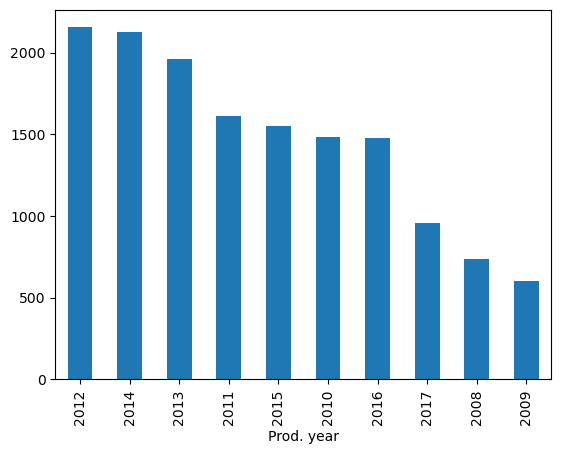

In [4]:
df['Prod. year'].value_counts().head(10).plot.bar()

<Axes: xlabel='Manufacturer'>

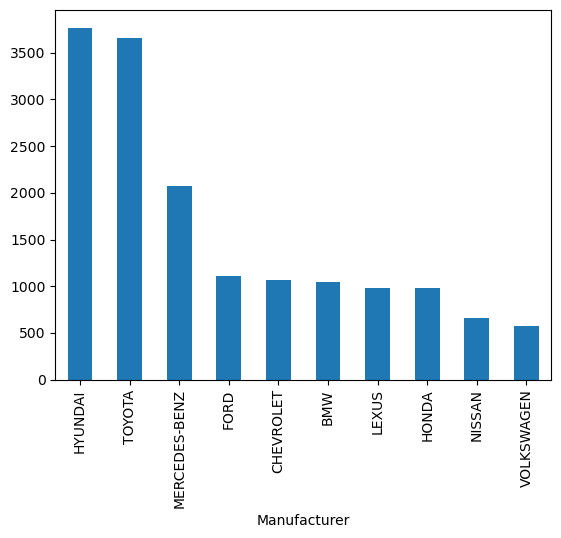

In [5]:
df['Manufacturer'].value_counts().head(10).plot.bar()

<Axes: xlabel='Fuel type'>

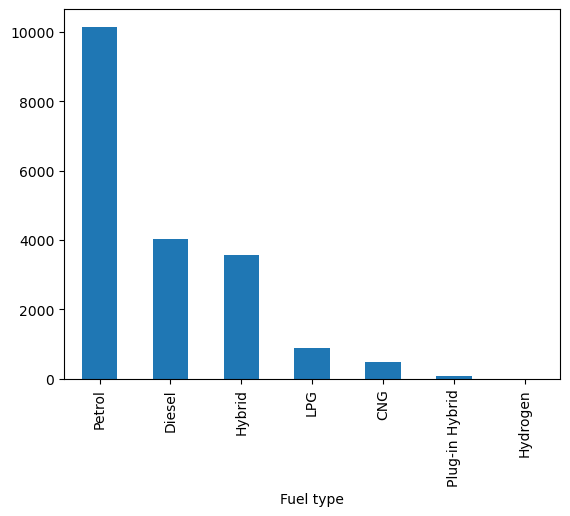

In [6]:
df['Fuel type'].value_counts().plot.bar()

<Axes: xlabel='Color'>

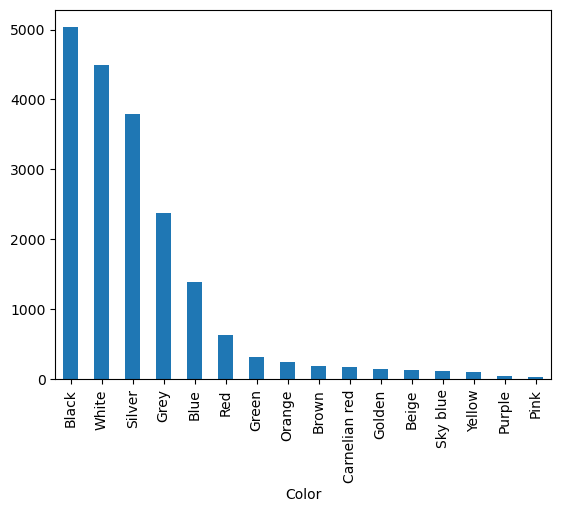

In [7]:
df['Color'].value_counts().plot.bar()

<Axes: ylabel='count'>

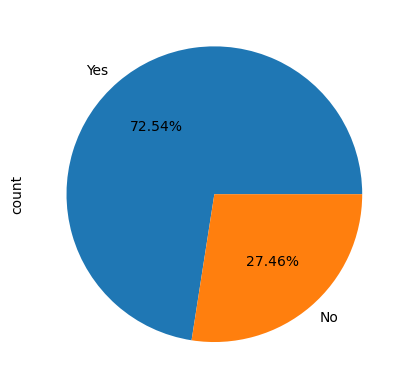

In [8]:
df['Leather interior'].value_counts().plot.pie(radius=1,autopct='%0.2f%%')

<strong><font size="5">Data Transformation</font></strong>

In [9]:
cat_col = [col for col in df.columns if df[col].dtype=='object']
cat_col

['Levy',
 'Manufacturer',
 'Model',
 'Category',
 'Leather interior',
 'Fuel type',
 'Engine volume',
 'Mileage',
 'Gear box type',
 'Drive wheels',
 'Doors',
 'Wheel',
 'Color']

<Axes: ylabel='Frequency'>

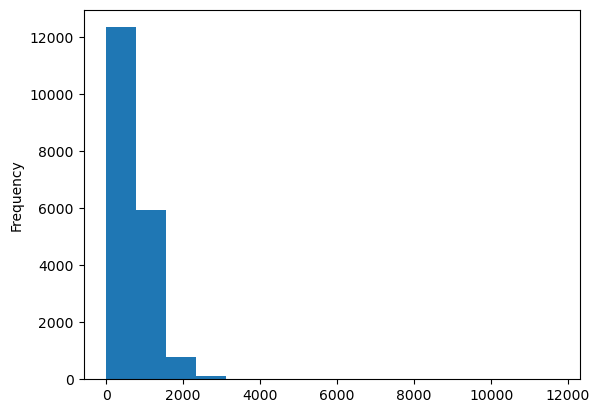

In [10]:
df.Levy = df.Levy.map(lambda x:0 if x== '-' else x)
df.Levy=df.Levy.astype('float')
df.Levy.plot.hist(bins=15)

In [11]:
df['Leather interior']=df['Leather interior'].map(lambda x:True if x== 'Yes' else False)
df['Leather interior']= df['Leather interior']*1

In [12]:
df.Mileage= df.Mileage.map(lambda x: x.rstrip(' km'))
df.Mileage= df.Mileage.astype('float')

In [13]:
df.Doors=df.Doors.map(lambda x: x.rstrip('-May'))
df.Doors=df.Doors.map(lambda x: x.rstrip('-Mar'))
df.Doors=df.Doors.map(lambda x: x.lstrip('>'))
df.Doors= df.Doors.astype('int')
df.Doors.value_counts()

Doors
4    18332
2      777
5      128
Name: count, dtype: int64

In [14]:
wheels= pd.get_dummies(df[['Wheel','Drive wheels','Gear box type', 'Fuel type']], prefix=['Wheel','Drive', 'Gear', 'Fuel'])
df =pd.concat([df, wheels], axis=1)
df.drop(['Wheel','Drive wheels','Gear box type', 'Fuel type'], axis=1, inplace=True)

In [15]:
df['Turbo']=df['Engine volume'].str.contains('Turbo')
df['Engine volume']=df['Engine volume'].map(lambda x:x.rstrip('Turbo'))
df['Engine volume']= df['Engine volume'].astype('float')

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19237 entries, 0 to 19236
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      19237 non-null  int64  
 1   Price                   19237 non-null  int64  
 2   Levy                    19237 non-null  float64
 3   Manufacturer            19237 non-null  object 
 4   Model                   19237 non-null  object 
 5   Prod. year              19237 non-null  int64  
 6   Category                19237 non-null  object 
 7   Leather interior        19237 non-null  int32  
 8   Engine volume           19237 non-null  float64
 9   Mileage                 19237 non-null  float64
 10  Cylinders               19237 non-null  float64
 11  Doors                   19237 non-null  int32  
 12  Color                   19237 non-null  object 
 13  Airbags                 19237 non-null  int64  
 14  Wheel_Left wheel        19237 non-null

In [17]:
Color_lb= LabelEncoder().fit(df['Color'])
Category_lb= LabelEncoder().fit(df['Category'])
Model_lb= LabelEncoder().fit(df['Model'])
Manufacturer_lb= LabelEncoder().fit(df['Manufacturer'])

df['Color_num']= Color_lb.transform(df['Color'])
df['Category_num']= Category_lb.transform(df['Category'])
df['Model_num']= Model_lb.transform(df['Model'])
df['Manufacturer_num']= Manufacturer_lb.transform(df['Manufacturer'])
    
df.drop(columns=['Color', 'Category','Model','Manufacturer'], inplace=True)
for col in ['Wheel_Left wheel','Wheel_Right-hand drive',
    'Drive_4x4', 'Drive_Front', 'Drive_Rear', 'Gear_Automatic','Gear_Manual','Gear_Tiptronic', 'Gear_Variator','Fuel_CNG',
         'Fuel_Diesel','Fuel_Hybrid', 'Fuel_Hydrogen','Fuel_LPG','Fuel_Petrol','Fuel_Plug-in Hybrid','Turbo']:
    df[col]= df[col]*1 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19237 entries, 0 to 19236
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      19237 non-null  int64  
 1   Price                   19237 non-null  int64  
 2   Levy                    19237 non-null  float64
 3   Prod. year              19237 non-null  int64  
 4   Leather interior        19237 non-null  int32  
 5   Engine volume           19237 non-null  float64
 6   Mileage                 19237 non-null  float64
 7   Cylinders               19237 non-null  float64
 8   Doors                   19237 non-null  int32  
 9   Airbags                 19237 non-null  int64  
 10  Wheel_Left wheel        19237 non-null  int32  
 11  Wheel_Right-hand drive  19237 non-null  int32  
 12  Drive_4x4               19237 non-null  int32  
 13  Drive_Front             19237 non-null  int32  
 14  Drive_Rear              19237 non-null

<strong><font size="5">Correlations</font></strong>

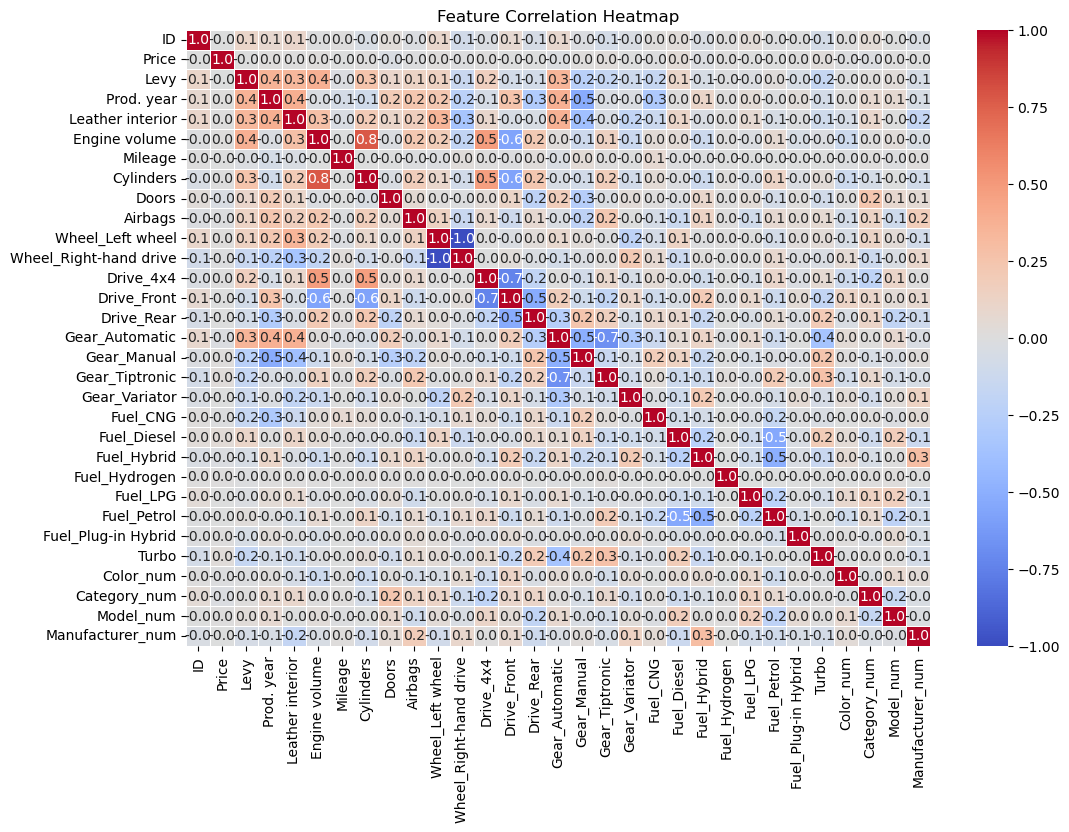

In [18]:
correlation_matrix = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".1f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

<strong><font size="5">Outliers</font></strong>

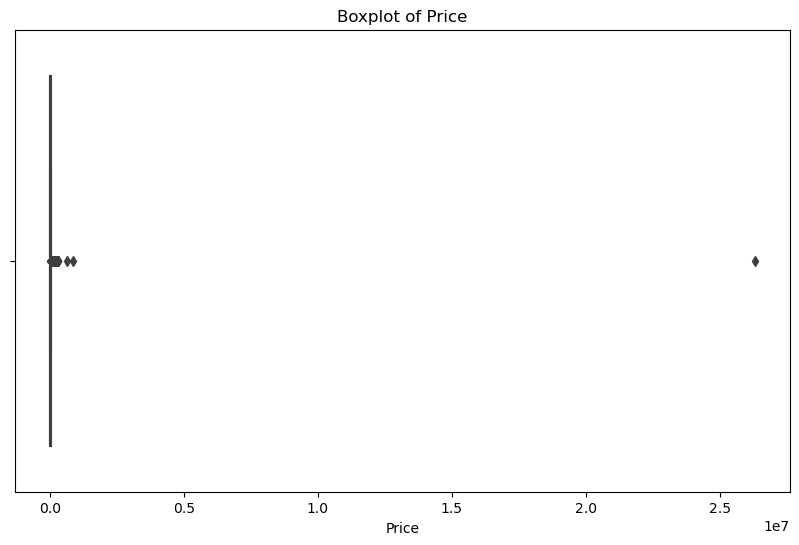

In [19]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['Price'])
plt.title("Boxplot of Price")
plt.show()

In [20]:
df['Log_Price'] = np.log(df.Price) 
X= df.drop(['Price','ID'],axis=1)
y= X.pop('Log_Price')

In [21]:
df.to_csv(r'D:/cleaned_car_data.csv', index=False, encoding='utf-8')

<strong><font size="5">Baseline Model</font></strong>

In [22]:
train_x, val_x, train_y,val_y = train_test_split(X,y,test_size= 0.2, random_state=89)

In [23]:
def cal_error(y_true, y_predict):
    print(f'r^2: {r2_score(y_true, y_predict)}')
    print(f'mae: {mean_absolute_error(y_true, y_predict)}')
    print(f'mse root: {np.sqrt(mean_squared_error(y_true, y_predict))}')

In [24]:
baseline_model = LinearRegression()
baseline_model.fit(train_x, train_y)

LinearRegression()

In [25]:
cal_error(val_y, baseline_model.predict(val_x))

r^2: 0.17019650330954572
mae: 1.0308487890682299
mse root: 1.4325770049245095


<strong><font size="5">Model Comparison</font></strong>

In [26]:
xgb_model = XGBRegressor(n_estimators= 1000,max_depth =100,early_stopping_rounds=25)
xgb_model.fit(train_x, train_y, eval_set=[(train_x, train_y),(val_x, val_y)] )

[0]	validation_0-rmse:1.20659	validation_1-rmse:1.32758
[1]	validation_0-rmse:0.92788	validation_1-rmse:1.19341
[2]	validation_0-rmse:0.72422	validation_1-rmse:1.12466
[3]	validation_0-rmse:0.57646	validation_1-rmse:1.09006
[4]	validation_0-rmse:0.46776	validation_1-rmse:1.07838
[5]	validation_0-rmse:0.38833	validation_1-rmse:1.07560
[6]	validation_0-rmse:0.33085	validation_1-rmse:1.07663
[7]	validation_0-rmse:0.28973	validation_1-rmse:1.07742
[8]	validation_0-rmse:0.26005	validation_1-rmse:1.07840
[9]	validation_0-rmse:0.23885	validation_1-rmse:1.08099
[10]	validation_0-rmse:0.22375	validation_1-rmse:1.08515
[11]	validation_0-rmse:0.21325	validation_1-rmse:1.08782
[12]	validation_0-rmse:0.20606	validation_1-rmse:1.08976
[13]	validation_0-rmse:0.20107	validation_1-rmse:1.09107
[14]	validation_0-rmse:0.19766	validation_1-rmse:1.09227
[15]	validation_0-rmse:0.19529	validation_1-rmse:1.09311
[16]	validation_0-rmse:0.19364	validation_1-rmse:1.09386
[17]	validation_0-rmse:0.19250	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=25,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=100, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [27]:
cal_error(val_y, xgb_model.predict(val_x))

r^2: 0.532223888981117
mae: 0.5715737927890113
mse root: 1.0755964618966283


In [28]:
rf_model = RandomForestRegressor(
    n_estimators=100,  
    max_depth=10,      
    random_state=89,   
    n_jobs=-1,         
    verbose=1         
)
rf_model.fit(train_x, train_y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished


RandomForestRegressor(max_depth=10, n_jobs=-1, random_state=89, verbose=1)

In [29]:
cal_error(val_y, rf_model.predict(val_x))

r^2: 0.5051822153723755
mae: 0.6679245878890977
mse root: 1.1062492665744732


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished


**Although Random forest model have better result than baseline model, the XGBoost model is better than Random forest in all R^2, MAE and MSE Root side.**

**So we choose XGBoost to ptimize model hyperparameters.**

<strong><font size="5">Hyperparameter Tuning</font></strong>

In [39]:
target_dir = 'C:\\Temp'

if not os.path.exists(target_dir):
    os.makedirs(target_dir)

temp_folder = tempfile.mkdtemp(prefix='joblib_', dir=target_dir)
os.environ['JOBLIB_TEMP_FOLDER'] = temp_folder

In [45]:
xgb_model = XGBRegressor()

param_grid = {
    'n_estimators': [500, 1000, 1500],  
    'max_depth': [3, 5, 7],        
    'learning_rate': [0.01, 0.1], 
    'subsample': [0.8, 1.0],       
    'colsample_bytree': [0.8, 1.0], 
    'early_stopping_rounds': [25]       
}

scorer = make_scorer(mean_absolute_error, greater_is_better=False)

cv = KFold(n_splits=2, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring=scorer,  
    cv=cv,           
    n_jobs=-1,      
    verbose=2       
)
with parallel_backend('loky'):
    grid_search.fit(train_x, train_y, eval_set=[(train_x, train_y), (val_x, val_y)])

print("Best Hyperparameters:", grid_search.best_params_)

Fitting 2 folds for each of 72 candidates, totalling 144 fits
[0]	validation_0-rmse:1.52039	validation_1-rmse:1.50657
[1]	validation_0-rmse:1.47112	validation_1-rmse:1.46208
[2]	validation_0-rmse:1.41523	validation_1-rmse:1.41203
[3]	validation_0-rmse:1.36334	validation_1-rmse:1.36617
[4]	validation_0-rmse:1.32046	validation_1-rmse:1.32914
[5]	validation_0-rmse:1.28035	validation_1-rmse:1.29572
[6]	validation_0-rmse:1.24848	validation_1-rmse:1.26906
[7]	validation_0-rmse:1.21977	validation_1-rmse:1.24475
[8]	validation_0-rmse:1.19971	validation_1-rmse:1.22912
[9]	validation_0-rmse:1.17663	validation_1-rmse:1.21018
[10]	validation_0-rmse:1.15373	validation_1-rmse:1.19207
[11]	validation_0-rmse:1.13456	validation_1-rmse:1.17751
[12]	validation_0-rmse:1.12084	validation_1-rmse:1.16739
[13]	validation_0-rmse:1.10622	validation_1-rmse:1.15653
[14]	validation_0-rmse:1.09463	validation_1-rmse:1.14871
[15]	validation_0-rmse:1.08215	validation_1-rmse:1.14053
[16]	validation_0-rmse:1.07227	valid

In [46]:
best_model = grid_search.best_estimator_
val_predictions = best_model.predict(val_x)
cal_error(val_y, val_predictions)

r^2: 0.6199112612952848
mae: 0.5499824801073345
mse root: 0.969555884919431


<strong><font size="5">Model Saving</font></strong>

In [48]:
best_model = grid_search.best_estimator_

with open('models/best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

print("Best model saved to 'best_model.pkl'")

Best model saved to 'best_model.pkl'


In [50]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15389 entries, 10659 to 6276
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Levy                    15389 non-null  float64
 1   Prod. year              15389 non-null  int64  
 2   Leather interior        15389 non-null  int32  
 3   Engine volume           15389 non-null  float64
 4   Mileage                 15389 non-null  float64
 5   Cylinders               15389 non-null  float64
 6   Doors                   15389 non-null  int32  
 7   Airbags                 15389 non-null  int64  
 8   Wheel_Left wheel        15389 non-null  int32  
 9   Wheel_Right-hand drive  15389 non-null  int32  
 10  Drive_4x4               15389 non-null  int32  
 11  Drive_Front             15389 non-null  int32  
 12  Drive_Rear              15389 non-null  int32  
 13  Gear_Automatic          15389 non-null  int32  
 14  Gear_Manual             15389 non-null  